# Flux ANNA Analysis Tutorial

This notebook demonstrates how to optimize Flux models using **ANNA** (Automatic Neural Network Analysis) quantization analysis, with the help of the **Qlip** package.

Quantization is a method used to lower the computational and memory requirements of inference by encoding weights and activations with low-precision formats, such as 8-bit integers (int8), instead of the standard 32-bit floating-point (float32).

By reducing the bit width, the model becomes more memory-efficient, potentially uses less power, and enables faster operations like matrix multiplications through integer arithmetic. This also makes it possible to deploy models on embedded devices, which may only support integer computations.

**ANNA** is a framework designed to automatically identify optimal model compression configurations by exploring various algorithms and hyperparameters, while assessing the trade-offs between model size, performance, and accuracy.

In this tutorial, we'll focus specifically on quantization as our acceleration technique, exploring how **ANNA** automatically finds optimal quantized configurations for Flux text-to-image model.

## Tutorial Overview

This comprehensive tutorial covers:
- Loading and configuring Flux models (dev/schnell) for text-to-image generation
- Understanding PTQ (Post-Training Quantization) configuration options
- Setting up quantization analysis using PipelineAnalyser  
- Running **ANNA** to generate series of optimal quantized configurations
- Visualizing compression vs quality trade-offs through real loss metrics
- Evaluating results with image generation tasks and quality benchmarks
- Comparing **ANNA's** selective approach with full model quantization



## Setup and Imports

We start by importing the necessary libraries and utility functions. The `flux_tutorial_utils` module contains helper functions specifically designed for working with Flux models and **ANNA** analysis.

In [1]:
import os
import sys

# Add project root to path for accessing modules
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./'))))

# Core PyTorch and model loading
import torch
from diffusers import DiffusionPipeline

# NVIDIA quantization configurations
from qlip.deploy.nvidia import NVIDIA_FLOAT_W8A8, NVIDIA_INT_W8A8  # Pre-configured quantization schemes
from qlip_algorithms.anna import PTQBag  # Post-Training Quantization algorithm container
from qlip_algorithms.anna import PipelineAnalyser # Specialized pipeline for Anna analysis

# Flux-specific utilities for ANNA analysis
from flux_tutorial_utils import (
    evaluate_configurations,  # Configuration evaluation with image generation
    set_seed,  # Reproducibility utility
    load_dataset_prompts,  # Dataset prompt loading for calibration
    create_flux_model_configs,  # Flux model configuration helper
    visualize_analysis_results,  # Trade-off visualization (real_loss vs objective_loss)
    generate_example_results,  # Example generation with different configurations
    visualize_quality_metrics,  # Quality metrics visualization
    get_validation_prompts,  # Validation prompts for evaluation
    show_images # Visualization
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-08-04 08:01:41: Qlip: INFO: Node on local rank 0 was initialized: 
 
Compute unit: cuda
Available devices:
    Device type: cuda; Device index: 0; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 1; Name: NVIDIA H100 80GB HBM3
    Device type

## Setup Device and Dtype

We configure the computation device (GPU if available) and the data type for model weights. Using `bfloat16` provides a good balance between memory efficiency and numerical precision for diffusion models.

In [2]:
# Setup device and dtype
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.bfloat16

print(f"Using device: {device}, dtype: {dtype}")

# IMPORTANT: Set your HuggingFace token here (required for Flux!)
hf_token = None  # Replace with your actual token
if not hf_token:
    print("\nWARNING: HuggingFace token is required for Flux!")
    print("Please set hf_token variable to your HuggingFace token.")

Using device: cuda, dtype: torch.bfloat16

Please set hf_token variable to your HuggingFace token.


## Model Selection and Configuration

Flux offers two main variants:
- **Flux.1-dev**: Higher quality model with 12B parameters, requires 28+ inference steps
- **Flux.1-schnell**: Speed-optimized model, works well with just 4 inference steps

Each model has different optimal settings for image generation, which we configure here.

In [3]:
# Choose Flux model (dev for quality, schnell for speed)
model_choice = 'flux-dev'  # Change to 'flux-schnell' for faster model

model_configs = create_flux_model_configs()
selected_config = model_configs[model_choice]

model_name = selected_config['model_name']
recommended_steps = selected_config['recommended_steps']
recommended_guidance = selected_config['recommended_guidance']
recommended_size = selected_config['recommended_size']

print(f"Selected model: {selected_config['description']}")
print(f"Model name: {model_name}")
print(f"Recommended steps: {recommended_steps}")
print(f"Recommended guidance: {recommended_guidance}")
print(f"Recommended size: {recommended_size}x{recommended_size}")

Selected model: Flux Dev - High quality text-to-image generation
Model name: black-forest-labs/FLUX.1-dev
Recommended steps: 28
Recommended guidance: 3.5
Recommended size: 1024x1024


## Create Directories

In [4]:
# Set seed for reproducibility
set_seed(42)

# Create output directories
os.makedirs('./flux_anna_results', exist_ok=True)
os.makedirs('./flux_activations', exist_ok=True)

## Load Flux Pipeline

Here we create the Flux diffusion pipeline using the HuggingFace Diffusers library. The pipeline includes the text encoder, transformer model, VAE, and scheduler components needed for text-to-image generation.

In [5]:
# Create Flux pipeline
print(f"Loading Flux pipeline: {model_name}")

pipeline = DiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    cache_dir='/mount/huggingface_cache',
    token=hf_token,
)
pipeline = pipeline.to(device)

print("Flux pipeline loaded successfully!")

Loading Flux pipeline: black-forest-labs/FLUX.1-dev


Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


Flux pipeline loaded successfully!


## Get Quantizable Blocks

The Flux transformer consists of multiple transformer blocks that can be quantized independently. We identify these blocks so that **ANNA** can analyze and optimize each one separately. This allows for fine-grained control over the quantization process.

In [6]:
# Get quantizable blocks from Flux transformer
model = pipeline.transformer
component_name = 'transformer'

modules_types = (torch.nn.Linear, torch.nn.Conv2d)
block_names = [
    name for name, module in model.named_modules()
    if isinstance(module, modules_types)
]

print(f"Component: {component_name}")
print(f"Found {len(block_names)} quantizable blocks")
print(f"First 5 blocks: {block_names[:5]}")

Component: transformer
Found 504 quantizable blocks
First 5 blocks: ['time_text_embed.timestep_embedder.linear_1', 'time_text_embed.timestep_embedder.linear_2', 'time_text_embed.guidance_embedder.linear_1', 'time_text_embed.guidance_embedder.linear_2', 'time_text_embed.text_embedder.linear_1']


## Configure Quantization

In order to set the quantization parameters (bit depth, quantization scheme, etc.), you can use predefined quantization schemes.

**Quantization Formats:**
- **FP8** (`NVIDIA_FLOAT_W8A8`): Supported from Ada Lovelace+ (L40s, RTX 4090, H100, B200). Faster on modern GPUs, maintains good quality
- **INT8** (`NVIDIA_INT_W8A8`): Supported from Turing+ (T4, RTX 3090, A100, RTX 4090, H100). More widely supported, provides better compression ratios

**Bag of algorithms configuration:**
The bag of algorithms defines a set of compression algorithms and their hyperparameters ANNA will select among.
Theoretically, more different choices will allow the analyser to find more flexible compression configurations
leading to higher quality of the compressed model, but it comes with a cost of longer analysis time and more data samples required for calibration.
We will use `PTQBag` - a collection of `PostTrainingQuantization` algorithms with options for percentile based scale estimation.

It takes the following parameters:

- **quantization_configs**: List of quantization schemes (FP8, INT8, etc.)
- **calibration_iterations**: Number of forward passes required for statistics collection
- **percentile_range** Range of percentiles values. Percentile defines how many outliers to exclude when estimating scale.
- **num_different_scales**: Number of different equal-spaced values in the percentile range to be used as options in the bag.

**ANNA** automatically combines these approaches to find the optimal quantization strategy for each model layer.

In [7]:
# Configure quantization settings
use_int8 = True  # Set to True for INT8, False for FP8
qconfig = NVIDIA_INT_W8A8 if use_int8 else NVIDIA_FLOAT_W8A8

# Quantization parameters explained:
# calibration_iterations: Number of forward passes to collect activation statistics
#   - More iterations = better statistics but longer calibration time
#   - 256 is usually sufficient for good results
calibration_iterations = 256  

# For simplicity we will set the number of different scales to 1. In this case min-max based quantization range estimation will be used and
# ANNA will decide whether to quantize the layer or keep it in original precision.
# If you set num_different_scales to a value greater than 1, ANNA will select the most optimal percentile value to use in scale estimation for each layer.
num_different_scales = 1      

# Create PTQBag with quantization configuration
bag_of_algorithms = PTQBag(
    quantization_configs=[qconfig],
    calibration_iterations=calibration_iterations,
    num_different_scales=num_different_scales,
)

print(f"Quantization config: {'INT8' if use_int8 else 'FP8'}")
print(f"Calibration iterations: {calibration_iterations}")
print(f"Scale exploration levels: {num_different_scales}")
print("ANNA will automatically explore the best quantization approach for each layer")

Quantization config: INT8
Calibration iterations: 256
Scale exploration levels: 1
ANNA will automatically explore the best quantization approach for each layer


## Load Dataset Prompts

Calibration prompts are crucial for **ANNA** analysis as they determine the activation patterns **ANNA** observes. Good calibration prompts should represent your target use cases and cover diverse scenarios.

In [8]:
# Load prompts from dataset for calibration
# Good calibration prompts should be diverse and representative of your target use cases
calibration_prompts = load_dataset_prompts(
    dataset_name='TempoFunk/webvid-10M',
    max_samples=100,
    hf_token=hf_token,
    cache_dir='/mount/huggingface_cache'
)

print(f"Loaded {len(calibration_prompts)} prompts from dataset")
print(f"First 3 prompts: {calibration_prompts[:3]}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'TempoFunk/webvid-10M' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset: TempoFunk/webvid-10M
Loaded 100 prompts from dataset
Loaded 100 prompts from dataset
First 3 prompts: ['Aerial shot winter forest', 'Senior couple looking through binoculars on sailboat together. shot on red epic for high quality 4k, uhd, ultra hd resolution.', 'A beautiful cookie with oranges lies on a green tablecloth']


## Initialize Flux Analyser with PipelineAnalyser

For complex pipelines like diffusion models, collecting calibration data can be challenging.

The ``PipelineAnalyser`` class simplifies this by automatically capturing activations during pipeline execution.

Override ``run_pipeline_to_save_activations`` and it will be called automatically to generate calibration data for your target component. 

The FluxAnalyser is a specialized version of PipelineAnalyser designed for Flux.

The calibration process involves generating images with various prompts to collect representative latents tensors from the transformer model.

In [9]:
class FluxAnalyser(PipelineAnalyser):
    """
    Flux-specific analyser that inherits from PipelineAnalyser.
    Adapted for Flux text-to-image generation pipeline.
    """

    def __init__(self, pipeline, bag_of_algorithms, block_names, calibration_prompts,
                 component_name='transformer', activations_dataset_path='./activations',
                 max_calibration_samples=100, calibration_iterations=1024, 
                 dtype=torch.bfloat16, device='cuda',
                 hf_token=None, width=1024, height=1024,
                 num_inference_steps=28, guidance_scale=3.5):
        """
        Initialize FluxAnalyser with Flux-specific parameters.

        Args:
            pipeline: Flux pipeline
            bag_of_algorithms: Quantization algorithms
            block_names: Names of blocks to quantize
            component_name: Component name ('transformer' for Flux)
            activations_dataset_path: Path to save activations
            calibration_prompts: List of prompts for calibration
            max_calibration_samples: Maximum number of calibration samples
            calibration_iterations: Number of calibration iterations
            hf_token: HuggingFace token for dataset access
            width: Image width for generation
            height: Image height for generation
            num_inference_steps: Number of denoising steps
            guidance_scale: Guidance scale for generation
        """
        self.calibration_prompts = calibration_prompts
        self.max_calibration_samples = max_calibration_samples
        self.hf_token = hf_token
        self.width = width
        self.device = device
        self.height = height
        self.num_inference_steps = num_inference_steps
        self.guidance_scale = guidance_scale

        super().__init__(
            pipeline=pipeline,
            bag_of_algorithms=bag_of_algorithms,
            block_names=block_names,
            component_name=component_name,
            activations_dataset_path=activations_dataset_path,
            calibration_iterations=calibration_iterations,
            dtype=dtype,
            device=device,
        )

    def run_pipeline_to_save_activations(self):
        """Override to use Flux-specific prompts and parameters."""
        print(f"Generating calibration data with {len(self.calibration_prompts)} prompts...")
        num_samples = min(self.max_calibration_samples, len(self.calibration_prompts))
        selected_prompts = self.calibration_prompts[:num_samples]

        for i, prompt in enumerate(tqdm(selected_prompts, desc="Generating calibration images")):
            print(f"Processing prompt {i+1}/{num_samples}: {prompt[:50]}...")
            try:
                with torch.no_grad():
                    result = self.pipeline(
                        prompt=prompt,
                        width=self.width,
                        height=self.height,
                        num_inference_steps=self.num_inference_steps,
                        guidance_scale=self.guidance_scale,
                        generator=torch.Generator(device=self.device).manual_seed(42 + i),
                    )
            except Exception as e:
                print(f"Error processing prompt {i}: {e}")
                continue


In [10]:
# Initialize FluxAnalyser with detailed parameter explanations
analyser = FluxAnalyser(
    # Core components
    pipeline=pipeline,                          # The Flux diffusion pipeline to analyze
    bag_of_algorithms=bag_of_algorithms,        # PTQ algorithms and configurations
    block_names=block_names,                    # List of quantizable layers (Linear, Conv2d)
    component_name=component_name,              # Component to analyze ('transformer')
    activations_dataset_path='./flux_activations',  # Where to save/load activation data
    # Calibration settings
    calibration_prompts=calibration_prompts,    # Text prompts for collecting activations
    max_calibration_samples=50,                 # Max number of prompts to use for calibration
    calibration_iterations=1024,                # Total iterations for loss estimation
    # Model settings
    dtype=dtype,                                # Model precision (bfloat16)
    hf_token=hf_token,                          # HuggingFace token for model access
    # Generation settings for calibration
    width=recommended_size,                     # Image width for calibration
    height=recommended_size,                    # Image height for calibration  
    num_inference_steps=recommended_steps,      # Denoising steps per generation
    guidance_scale=recommended_guidance         # Classifier-free guidance strength
)

print("FluxAnalyser initialized successfully!")
print(f"Using {len(analyser.calibration_prompts)} calibration prompts")
print(f"Image size: {recommended_size}x{recommended_size}")
print(f"Inference steps: {recommended_steps}")
print(f"Guidance scale: {recommended_guidance}")

Calibrating: 100%|██████████| 256/256 [01:24<00:00,  3.03it/s]

FluxAnalyser initialized successfully!
Using 100 calibration prompts
Image size: 1024x1024
Inference steps: 28
Guidance scale: 3.5


## Run **ANNA** Analysis

To explore trade-offs between model size and quality, run the analysis and generate a series of optimal quantization configurations with different sizes within specified range.

The result is a list of 10 ``ANNAResult`` objects with selected compression configurations, constraint values and some additional info.

In [11]:
print("Running ANNA analysis with 10 configurations...")
print("Constraint range: 0.502 to 1.0 (size)")

# Run ANNA analysis with detailed parameter explanations
results = analyser.run(
    min_constraint_value=0.5,  # Minimum model size ratio (50% of original). corresponds to full quantized model.
                               # If the constraint value is not feasible ANNA will clamp it to the nearest feasible value.
    
    max_constraint_value=1.0,  # Maximum model size ratio (100% = original size) corresponds to original model
    
    constraint_type='size',    # What to optimize for:
                               # 'size' = model memory footprint
                               # 'macs' = computational complexity (multiply-accumulate operations)
    
    num_configs=10,            # Number of different configurations to generate
                               # More configs = better coverage of the quality-size trade-off curve
)

print(f"\nAnalysis completed! Generated {len(results)} configurations.")
print("Each configuration represents a different compression/quality trade-off point.")

Running ANNA analysis with 10 configurations...
Constraint range: 0.502 to 1.0 (size)
Feasible interval: tensor(0.5001) tensor(1.)
Estimating loss...


Estimating loss: 100%|██████████| 1024/1024 [10:57<00:00,  1.56it/s]
/usr/local/lib/python3.10/dist-packages/qlip/analysis/optimization/expression.py:72: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  return x @ self.b.T + self.c


Evaluating real loss for 0.5


Evaluating real loss: 100%|██████████| 32/32 [00:32<00:00,  1.03s/it]


Evaluating real loss for 0.56


Evaluating real loss: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s]


Evaluating real loss for 0.61


Evaluating real loss: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Evaluating real loss for 0.67


Evaluating real loss: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


Evaluating real loss for 0.72


Evaluating real loss: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Evaluating real loss for 0.78


Evaluating real loss: 100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Evaluating real loss for 0.83


Evaluating real loss: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Evaluating real loss for 0.89


Evaluating real loss: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


Evaluating real loss for 0.94


Evaluating real loss: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Evaluating real loss for 1.0


Evaluating real loss: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s]


Analysis completed! Generated 10 configurations.
Each configuration represents a different compression/quality trade-off point.


## Visualize Analysis Results

Let's visualize the trade-off between model compression (constraint) and quality degradation (real loss). 

**Understanding the metrics:**
- **Constraint**: The fraction of original model size (0.5 = 50% of original size, 1.0 = 100% original size)
- **Real Loss**: The computed difference between original and quantized model outputs (lower = better quality preservation)
- **Objective Loss**: **ANNA's** predicted loss based on calibration data (used during optimization)

The plot helps identify the "elbow" - the point where further compression leads to significant quality degradation.

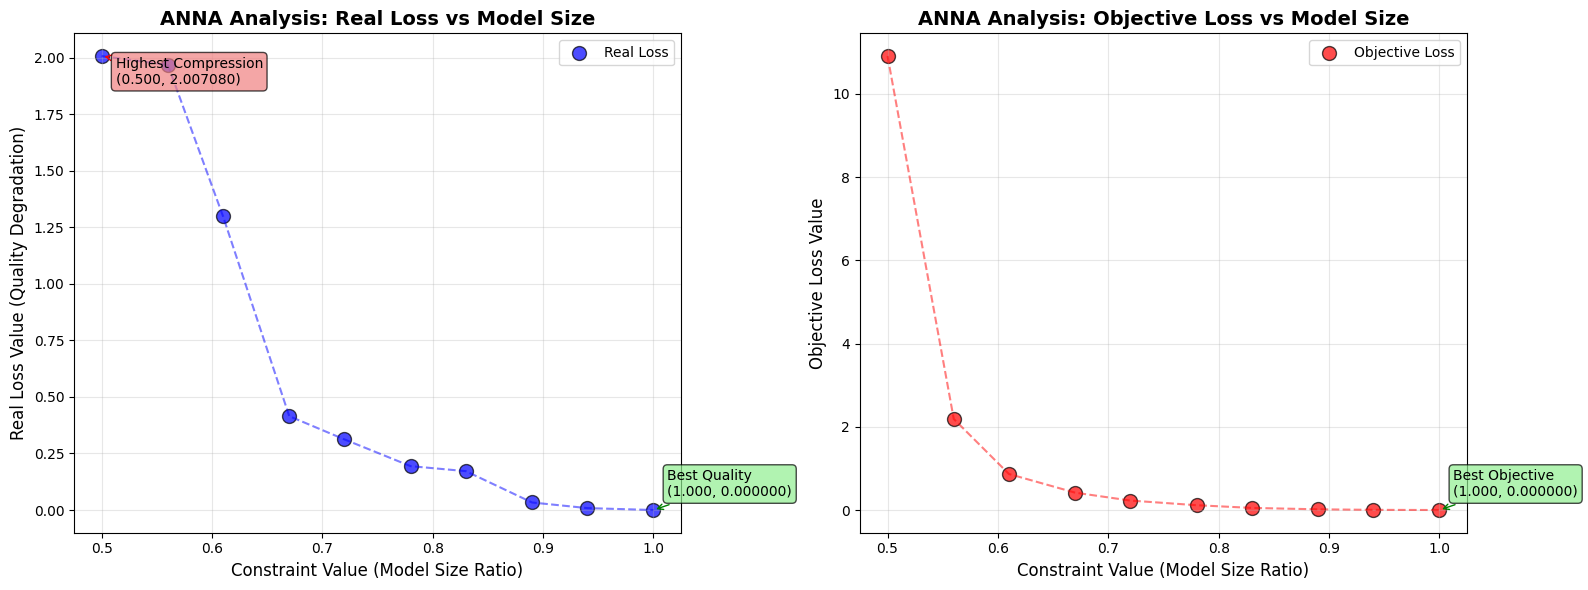

Analysis shows 10 configurations ranging from 0.500 to 1.000 model size ratio
Real Loss range: 0.000000 to 2.007080
Objective Loss range: 0.000000 to 10.909483


In [12]:
# Visualize the analysis results
visualize_analysis_results(results)

## Save Configurations

Each **ANNA** result contains a complete quantization configuration that can be applied to the model. We save these configurations to disk so they can be loaded and used later.

The configurations are saved as files that specify exactly which layers to quantize and with what settings.

In [13]:
# Save configurations to disk
print("\nSaving configurations:")
for i, result in enumerate(results):
    result.save('./flux_anna_results')
    print(f"Configuration {i+1}: constraint={result.constraint_value:.3f}, "
          f"objective={result.objective_value:.6f}")

print(f"\nConfigurations saved to ./flux_anna_results/")

# Clean up ANNA blocks
analyser.anna_model.remove_anna_blocks()
print("ANNA blocks cleaned up.")


Saving configurations:
Configuration 1: constraint=0.500, objective=10.909483
Configuration 2: constraint=0.560, objective=2.187701
Configuration 3: constraint=0.610, objective=0.865519
Configuration 4: constraint=0.670, objective=0.417166
Configuration 5: constraint=0.720, objective=0.227289
Configuration 6: constraint=0.780, objective=0.115841
Configuration 7: constraint=0.830, objective=0.050804
Configuration 8: constraint=0.890, objective=0.016933
Configuration 9: constraint=0.940, objective=0.004250
Configuration 10: constraint=1.000, objective=0.000000

Configurations saved to ./flux_anna_results/
ANNA blocks cleaned up.


## Visual Comparison of Quantization Levels

Let's generate example images to visually compare how different compression levels affect image quality. We'll test three configurations: highest compression, balanced, and best quality.

Generating example images with different quantization levels...
This demonstrates how constraint values affect visual quality.

🔧 Testing Highest Compression (constraint=0.500)...
  Prompt: "A serene mountain landscape with a crystal clear lake reflecting the sky..."


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


  Prompt: "A futuristic city skyline at sunset with flying cars..."


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


  Prompt: "A detailed portrait of a wise old wizard with a long beard..."


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



🔧 Testing Balanced (constraint=0.780)...
  Prompt: "A serene mountain landscape with a crystal clear lake reflecting the sky..."


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


  Prompt: "A futuristic city skyline at sunset with flying cars..."


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


  Prompt: "A detailed portrait of a wise old wizard with a long beard..."


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]



🔧 Testing Best Quality (constraint=1.000)...
  Prompt: "A serene mountain landscape with a crystal clear lake reflecting the sky..."


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


  Prompt: "A futuristic city skyline at sunset with flying cars..."


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


  Prompt: "A detailed portrait of a wise old wizard with a long beard..."


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


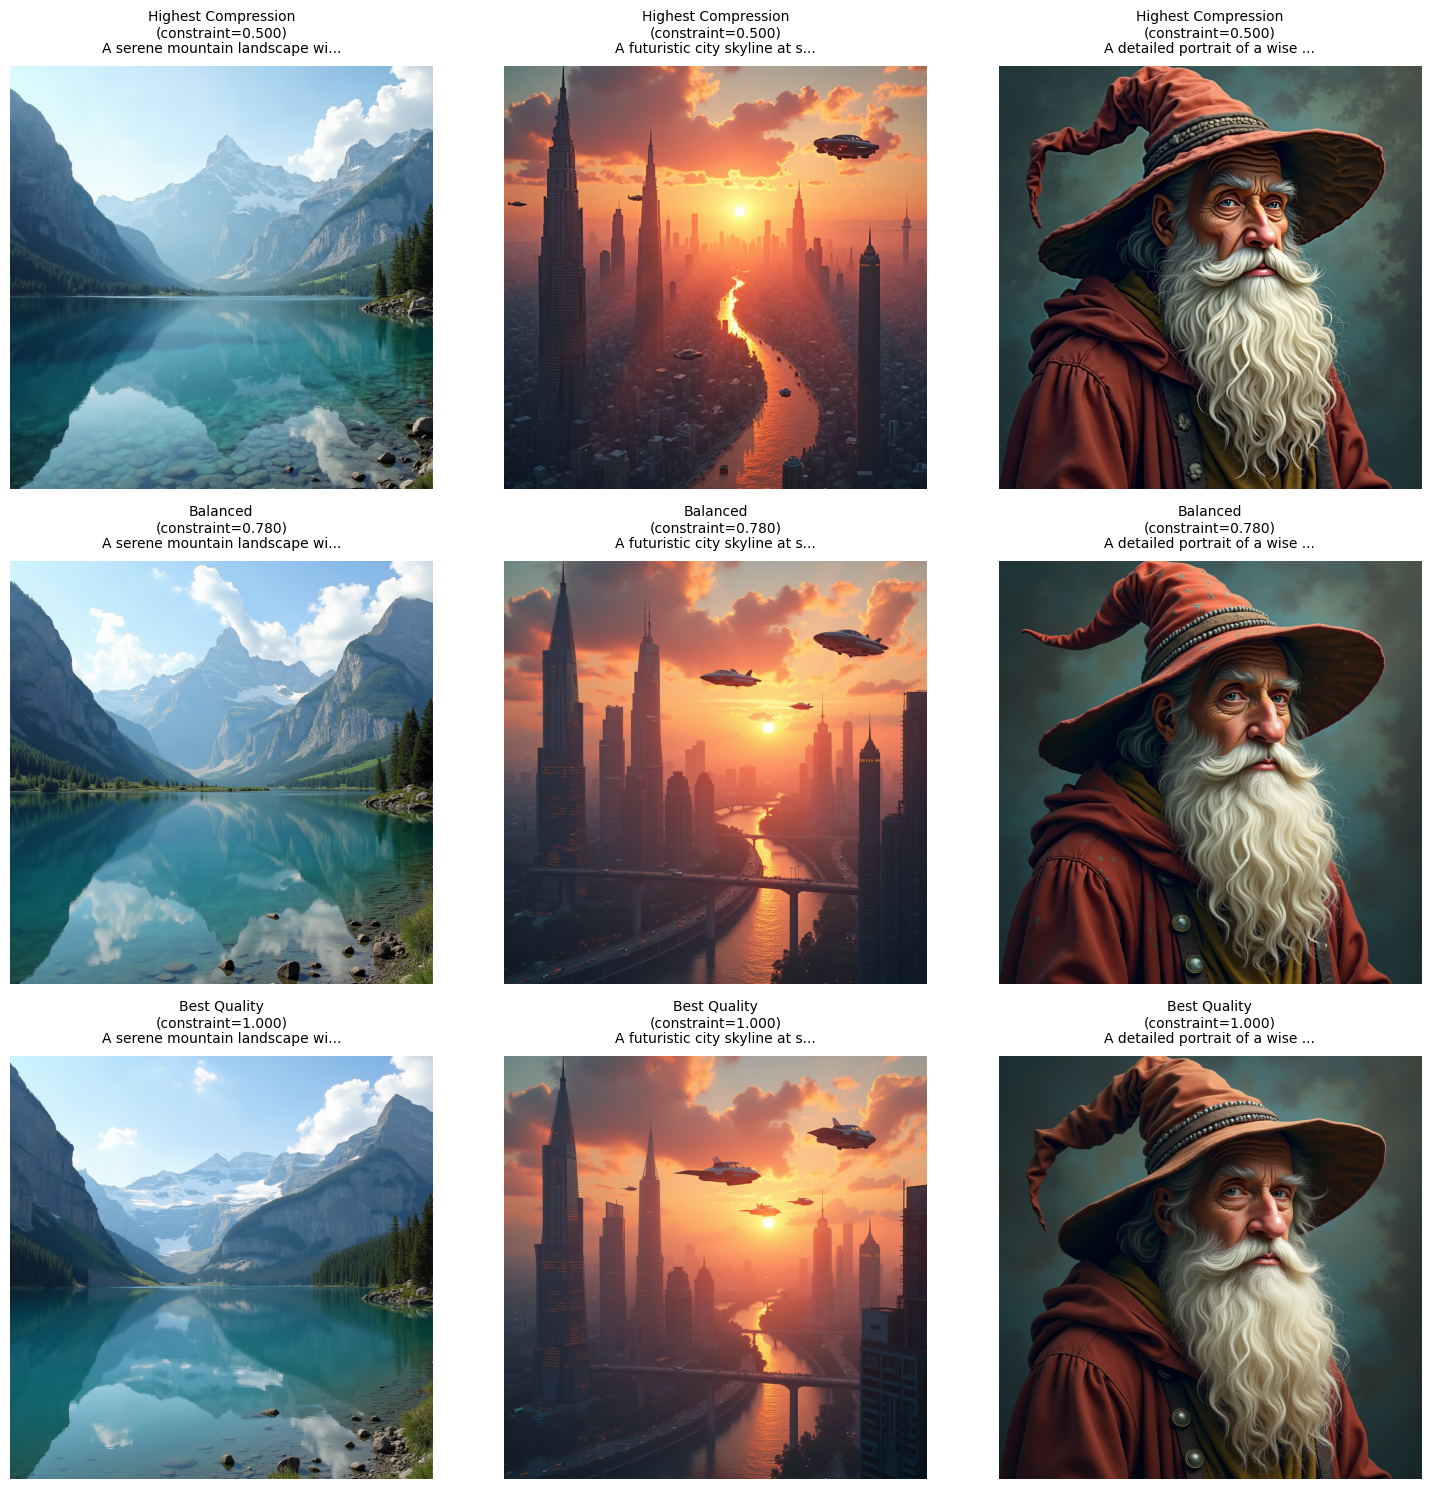


Comparison Summary:
  • Highest Compression: constraint=0.500, objective=10.909483
  • Balanced: constraint=0.780, objective=0.115841
  • Best Quality: constraint=1.000, objective=0.000000

Key Observations:
  • Higher compression (lower constraint) = smaller model size but potentially lower quality
  • Lower compression (higher constraint) = larger model size but better quality preservation
  • The optimal balance depends on your specific use case and quality requirements


In [14]:
# Generate example results with different configurations
generate_example_results(
    analyser=analyser, 
    results=results, 
    pipeline=pipeline,
    recommended_size=recommended_size,
    recommended_steps=recommended_steps,
    recommended_guidance=recommended_guidance,
    show_examples=True
)

## Evaluate Configurations with Quality Metrics

To quantitatively assess the quality of each quantized configuration, we generate test images and evaluate them using standard image quality metrics.

**Understanding Image Quality Metrics:**

1. **PSNR (Peak Signal-to-Noise Ratio)** - Measures pixel-level differences
   - Range: 0 to ∞ (higher is better)
   - >30 = Good quality, >40  = Excellent quality
   - Focuses on mathematical differences, may not reflect perceptual quality

2. **SSIM (Structural Similarity Index)** - Measures structural similarity
   - Range: 0 to 1 (higher is better)
   - >0.9 = Very good, >0.95 = Excellent
   - Better aligned with human perception than PSNR

3. **FID (Fréchet Inception Distance)** - Measures distribution similarity
   - Range: 0 to ∞ (lower is better)
   - <10 = Good, <5 = Excellent
   - Compares feature distributions using a pre-trained network

4. **CLIP Score** - Measures text-image alignment
   - Range: 0 to 1 (higher is better)
   - >0.3 = Good alignment
   - Evaluates how well the image matches the text prompt

In [ ]:
# First, generate evaluation images for all configurations
print("Generating evaluation images for all configurations...")
evaluate_configurations(
    analyser=analyser,
    results=results,
    output_dir='./flux_anna_results'
)

print("\nEvaluation images generated! Now calculating quality metrics...")

# Import benchmark utilities
from qlip_algorithms.evaluation import PSNRMetric, SSIMMetric, FIDMetric, CLIPScoreMetric

# Get validation prompts from utils
# validation_prompts = get_validation_prompts()
validation_prompts = [
    "A majestic lion standing on a rocky cliff at sunset",
    "A futuristic city skyline with flying cars and neon lights",
    "A beautiful garden with blooming flowers and butterflies",
    "An astronaut walking on the surface of an alien planet",
    "A vintage steam train crossing a stone bridge in the mountains",
    "A colorful hot air balloon floating over a green valley",
    "A magical forest with glowing mushrooms and fairy lights",
    "A cozy cabin in the woods with smoke coming from the chimney",
    "A bustling marketplace in an ancient city",
    "A serene lake reflecting snow-capped mountains at dawn"
]
print(f"Using {len(validation_prompts)} diverse validation prompts for evaluation")

# Calculate metrics for each configuration
output_dir = './flux_anna_results'
all_scores = {}

print("\n" + "="*60)
print("CALCULATING IMAGE QUALITY METRICS")
print("="*60)

for i, result in enumerate(results):
    print(f"\nEvaluating configuration {i+1}/{len(results)} (constraint={result.constraint_value:.3f})...")
    scores = {}
    generated_images = os.path.join(output_dir, 'eval_results', f'{result.constraint_value:.4f}', 'evaluation_images')
    target_images = os.path.join(output_dir, 'eval_results', f'{1.0000:.4f}', 'evaluation_images')
    prompts = validation_prompts

    scores['PSNR'] = PSNRMetric().evaluate(
        generated_images=generated_images, target_images=target_images, prompts=prompts,
    )
    scores['SSIM'] = SSIMMetric().evaluate(
        generated_images=generated_images, target_images=target_images, prompts=prompts,
    )
    scores['FID'] = FIDMetric().evaluate(
        generated_images=generated_images, target_images=target_images, prompts=prompts,
    )
    scores['CLIP'] = CLIPScoreMetric().evaluate(
        generated_images=generated_images, target_images=target_images, prompts=prompts,
    )

    # Register scores with the result
    result.register_benchmarks(scores)
    result.save(output_dir)

    # Store scores for summary
    all_scores[result.constraint_value] = scores

    # Display results
    print(f"✓ Configuration {result.constraint_value:.3f} metrics:")
    print(f"  - PSNR: {scores['PSNR']}")
    print(f"  - SSIM: {scores['SSIM']}")
    print(f"  - FID: {scores['FID']}")
    print(f"  - CLIP: {scores['CLIP']}")

# Display summary table
print("\n" + "="*70)
print("BENCHMARK EVALUATION SUMMARY")
print("-" * 70)

for constraint, scores in sorted(all_scores.items()):
    print(f"{constraint} {scores['PSNR']} {scores['SSIM']} "
          f"{scores['FID']}")# {scores['CLIP']}")

print("\nEvaluation completed! Results saved in ./flux_anna_results/")
print("Generated images: ./flux_anna_results/eval_results/<constraint>/evaluation_images/")
print("Metrics saved with each configuration")

Generating evaluation images for all configurations...
Evaluating configurations with image generation...

Generating images for configuration 1 (constraint=0.5000)...


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_000.png


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_001.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_002.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_003.png


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_004.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_005.png


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_006.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_007.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_008.png


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Saved: ./flux_anna_results/eval_results/0.5000/evaluation_images/image_009.png
Generated images for configuration 0.5000

Generating images for configuration 2 (constraint=0.5600)...


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_000.png


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_001.png


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_002.png


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_003.png


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_004.png


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_005.png


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_006.png


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_007.png


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_008.png


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Saved: ./flux_anna_results/eval_results/0.5600/evaluation_images/image_009.png
Generated images for configuration 0.5600

Generating images for configuration 3 (constraint=0.6100)...


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_000.png


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_001.png


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_002.png


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_003.png


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_004.png


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_005.png


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_006.png


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_007.png


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_008.png


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Saved: ./flux_anna_results/eval_results/0.6100/evaluation_images/image_009.png
Generated images for configuration 0.6100

Generating images for configuration 4 (constraint=0.6700)...


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_000.png


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_001.png


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_002.png


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_003.png


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_004.png


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_005.png


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_006.png


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_007.png


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_008.png


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Saved: ./flux_anna_results/eval_results/0.6700/evaluation_images/image_009.png
Generated images for configuration 0.6700

Generating images for configuration 5 (constraint=0.7200)...


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_000.png


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_001.png


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_002.png


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_003.png


100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_004.png


100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_005.png


100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_006.png


100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_007.png


100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_008.png


100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Saved: ./flux_anna_results/eval_results/0.7200/evaluation_images/image_009.png
Generated images for configuration 0.7200

Generating images for configuration 6 (constraint=0.7800)...


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_000.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_001.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_002.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_003.png


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_004.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_005.png


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_006.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_007.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_008.png


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Saved: ./flux_anna_results/eval_results/0.7800/evaluation_images/image_009.png
Generated images for configuration 0.7800

Generating images for configuration 7 (constraint=0.8300)...


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_000.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_001.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_002.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_003.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_004.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_005.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_006.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_007.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_008.png


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Saved: ./flux_anna_results/eval_results/0.8300/evaluation_images/image_009.png
Generated images for configuration 0.8300

Generating images for configuration 8 (constraint=0.8900)...


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_000.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_001.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_002.png


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_003.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_004.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_005.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_006.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_007.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_008.png


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Saved: ./flux_anna_results/eval_results/0.8900/evaluation_images/image_009.png
Generated images for configuration 0.8900

Generating images for configuration 9 (constraint=0.9400)...


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_000.png


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_001.png


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_002.png


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_003.png


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_004.png


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_005.png


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_006.png


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_007.png


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_008.png


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Saved: ./flux_anna_results/eval_results/0.9400/evaluation_images/image_009.png
Generated images for configuration 0.9400

Generating images for configuration 10 (constraint=1.0000)...


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_000.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_001.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_002.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_003.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_004.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_005.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_006.png


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_007.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_008.png


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Saved: ./flux_anna_results/eval_results/1.0000/evaluation_images/image_009.png
Generated images for configuration 1.0000

Evaluation images generated! Now calculating quality metrics...
Using 10 diverse validation prompts for evaluation

CALCULATING IMAGE QUALITY METRICS

Evaluating configuration 1/10 (constraint=0.500)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	CLIP


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Configuration 0.500 metrics:
  - PSNR: 29.6661144008164
  - SSIM: 0.7274849167265991
  - FID: 0.0004545822195457308
  - CLIP: 0.33505607604980464

Evaluating configuration 2/10 (constraint=0.560)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.560 metrics:
  - PSNR: 29.70846137744342
  - SSIM: 0.7131670221827571
  - FID: 0.00013129732855764672
  - CLIP: 0.3398661804199219

Evaluating configuration 3/10 (constraint=0.610)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.610 metrics:
  - PSNR: 29.942855426816674
  - SSIM: 0.730429300056274
  - FID: 6.049396389544576e-05
  - CLIP: 0.3392057418823242

Evaluating configuration 4/10 (constraint=0.670)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.670 metrics:
  - PSNR: 29.878245899660186
  - SSIM: 0.728827445976455
  - FID: 5.272449298458978e-05
  - CLIP: 0.34037273406982427

Evaluating configuration 5/10 (constraint=0.720)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.720 metrics:
  - PSNR: 30.084097099985875
  - SSIM: 0.7422664415637948
  - FID: 9.477807470504584e-05
  - CLIP: 0.3415346527099609

Evaluating configuration 6/10 (constraint=0.780)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.780 metrics:
  - PSNR: 30.319062446514216
  - SSIM: 0.7444446214866388
  - FID: 9.345546889405338e-05
  - CLIP: 0.34008422851562503

Evaluating configuration 7/10 (constraint=0.830)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.830 metrics:
  - PSNR: 31.84323762247442
  - SSIM: 0.8187645596089628
  - FID: 4.979705867807008e-05
  - CLIP: 0.3365964508056641

Evaluating configuration 8/10 (constraint=0.890)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.890 metrics:
  - PSNR: 32.920628760643424
  - SSIM: 0.8578338146976142
  - FID: 2.9802386003544012e-05
  - CLIP: 0.33634902954101564

Evaluating configuration 9/10 (constraint=0.940)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 0.940 metrics:
  - PSNR: 34.302299473929864
  - SSIM: 0.8937181902987806
  - FID: 1.749924584787399e-05
  - CLIP: 0.3359415817260743

Evaluating configuration 10/10 (constraint=1.000)...
Calculating benchmarks...
	PSNR
	SSIM
	FID


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


	CLIP
✓ Configuration 1.000 metrics:
  - PSNR: inf
  - SSIM: 1.0
  - FID: 0.0
  - CLIP: 0.33599506378173827

BENCHMARK EVALUATION SUMMARY
----------------------------------------------------------------------
0.5 29.6661144008164 0.7274849167265991 0.0004545822195457308
0.56 29.70846137744342 0.7131670221827571 0.00013129732855764672
0.61 29.942855426816674 0.730429300056274 6.049396389544576e-05
0.67 29.878245899660186 0.728827445976455 5.272449298458978e-05
0.72 30.084097099985875 0.7422664415637948 9.477807470504584e-05
0.78 30.319062446514216 0.7444446214866388 9.345546889405338e-05
0.83 31.84323762247442 0.8187645596089628 4.979705867807008e-05
0.89 32.920628760643424 0.8578338146976142 2.9802386003544012e-05
0.94 34.302299473929864 0.8937181902987806 1.749924584787399e-05
1.0 inf 1.0 0.0

Evaluation completed! Results saved in ./flux_anna_results/
Generated images: ./flux_anna_results/eval_results/<constraint>/evaluation_images/
Metrics saved with each configuration


## Visualize Quality Metrics

Let's visualize how the quality metrics change with different compression levels to better understand the trade-offs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


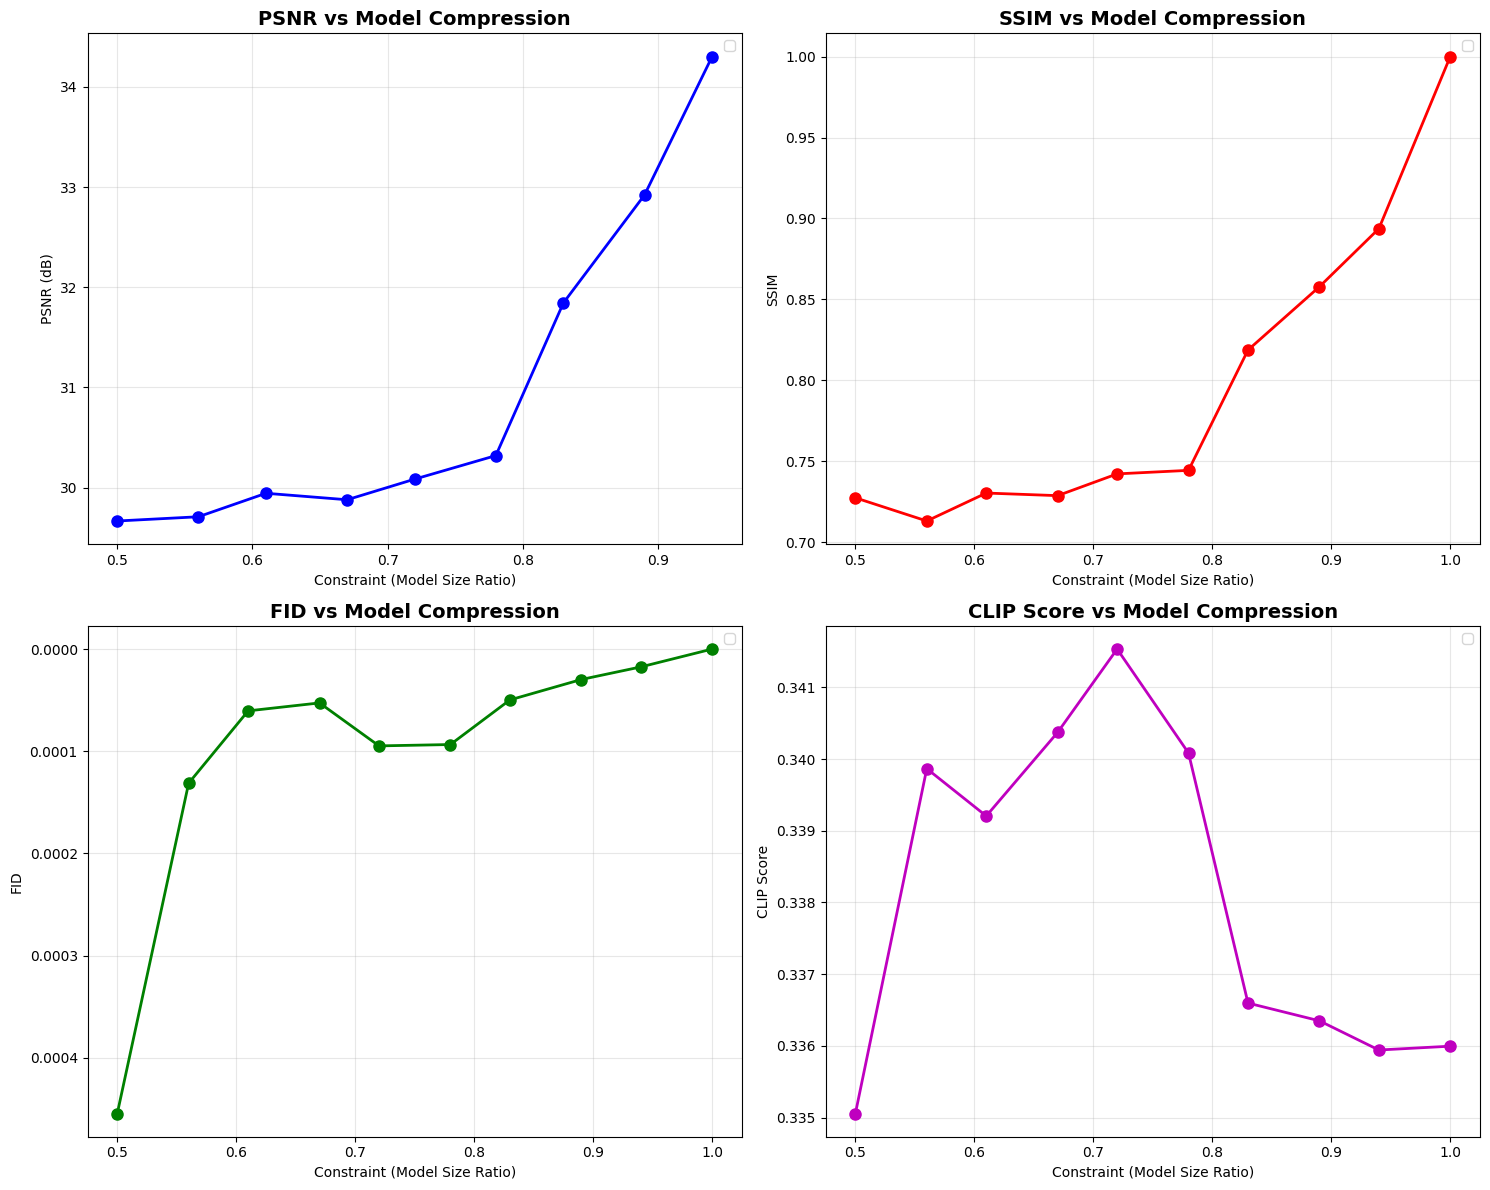

In [16]:
# Visualize quality metrics
visualize_quality_metrics(all_scores)

## Test a Specific Configuration

Here we demonstrate how to apply a specific quantization configuration to the model and test it with image generation. This shows the complete workflow from analysis to application.

In [16]:
# Apply and test a specific configuration
config_index = 0  # Choose configuration index (0 = most compressed, -1 = least compressed)

if len(results) > config_index:
    print(f"\nTesting configuration {config_index + 1} (constraint={results[config_index].constraint_value:.4f})")

    # Apply configuration
    results[config_index].anna_config.apply(analyser.model)
    analyser.model.to(analyser.pipeline.device)

    # Test image generation with quantized model
    test_prompt = "A beautiful sunset over a calm lake with mountains in the background"

    print(f"Testing quantized model with prompt: '{test_prompt}'")
    with torch.no_grad():
        result = pipeline(
            prompt=test_prompt,
            width=recommended_size,
            height=recommended_size,
            num_inference_steps=recommended_steps,
            guidance_scale=recommended_guidance,
            generator=torch.Generator(device=analyser.pipeline.device).manual_seed(42),
        )

    print("Quantized model generation successful!")

    # Remove configuration
    results[config_index].anna_config.remove()
    print("Configuration removed.")


Testing configuration 1 (constraint=0.5000)
Testing quantized model with prompt: 'A beautiful sunset over a calm lake with mountains in the background'


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]

Quantized model generation successful!
Configuration removed.


## PostTrainingQuantization

In the previous steps, we carefully analyzed and identified optimal quantization configurations for different layers of the model by **ANNA**. This approach allowed us to maximize quality while improving efficiency.

`PostTrainingQuantization` class from library **Qlip** provides static and dynamic quantization with advanced observers for accurate scale/zero-point estimation. It supports flexible granularities (per-tensor, per-channel, per-token) and custom quantization schemes including INT4/8 and FP8.

Now, let's examine how standard full model quantization performs as a baseline comparison. In this approach:

- All Linear layers will be uniformly quantized to INT8
- We'll use 256 calibration iterations (the same total budget as our **ANNA** approach)
- The quantization will be applied without any layer-specific optimizations

This comparison will help us understand:

- The quality impact of quantizing all layers indiscriminately
- The benefits of our **ANNA** strategy
- The trade-offs between simplicity and performance

The test prompt will use identical generation parameters as our optimized tests for fair comparison.

In [18]:
# Import PostTrainingQuantization for full model quantization
from qlip_algorithms.quantization import PostTrainingQuantization
print("Setting up full model quantization for comparison...")
# Create a copy of the model for full quantization
full_quant_model = pipeline.transformer

# Apply full quantization to ALL Linear layers
quantized_model = PostTrainingQuantization.setup_model(
    model=full_quant_model,
    modules_types=(torch.nn.Linear, torch.nn.Conv2d),  # Quantize these type of layers
    calibration_iterations=256,  # Number of calibration iterations,
    **NVIDIA_INT_W8A8  # Use INT8 quantization
)
# Configure the quantized model
PostTrainingQuantization.configure_model(quantized_model[0])

print("✓ Full quantization setup complete")
print(f"  - All {len(block_names)} layers will be quantized")
print(f"  - Calibration iterations: 256")
print(f"  - Quantization type: INT8")

# Run calibration - need to run forward passes
print("\nRunning calibration for full quantization...")
num_calibration_prompts = (256 // recommended_steps) + 1  # Calculate how many prompts we need
calibration_prompts_subset = calibration_prompts[:num_calibration_prompts]

print(f"Using {len(calibration_prompts_subset)} prompts for calibration")

# Run calibration forward passes
with torch.no_grad():
    for i, prompt in enumerate(calibration_prompts_subset):
        print(f"Calibrating {i+1}/{len(calibration_prompts_subset)}: {prompt[:50]}...")
        _ = pipeline(
            prompt=prompt,
            width=recommended_size,
            height=recommended_size,
            num_inference_steps=recommended_steps,
            guidance_scale=recommended_guidance,
            generator=torch.Generator(device=device).manual_seed(42 + i),
        )

print("\n✓ Calibration complete!")

# Generate test images with full quantization
print("\nGenerating test image with full quantization...")
test_prompt = "A beautiful sunset over a calm lake with mountains in the background"
with torch.no_grad():
    quant_result = pipeline(
        prompt=test_prompt,
        width=recommended_size,
        height=recommended_size,
        num_inference_steps=recommended_steps,
        guidance_scale=recommended_guidance,
        generator=torch.Generator(device=device).manual_seed(42),
    )
#     result.images[0].show()

print("\n Full quantization test images generated!")


Setting up full model quantization for comparison...
✓ Full quantization setup complete
  - All 504 layers will be quantized
  - Calibration iterations: 256
  - Quantization type: INT8

Running calibration for full quantization...
Using 10 prompts for calibration
Calibrating 1/10: Aerial shot winter forest...


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Calibrating 2/10: Senior couple looking through binoculars on sailbo...


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Calibrating 3/10: A beautiful cookie with oranges lies on a green ta...


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Calibrating 4/10: Japanese highrise office skyscrapers tokyo square...


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Calibrating 5/10: Zrenjanin,serbia march 21 2015: fans watching live...


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Calibrating 6/10: Young beautiful woman using smartphone in cafe...


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Calibrating 7/10: 3d render of inky injections into water with luma ...


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Calibrating 8/10: Swimming in the pool ,slow motion 120 fps,handheld...


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Calibrating 9/10: Circa 1940s usa:  woman posing for camera next to ...


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Calibrating 10/10: Timor-leste scanned by software...


100%|██████████| 28/28 [00:11<00:00,  2.41it/s]



✓ Calibration complete!

Generating test image with full quantization...


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


 Full quantization test images generated!


To demonstrate the use of **ANNA**, we compare images from a fully quantized model and a model quantized by **ANNA's** configuration with a minimal constraint.

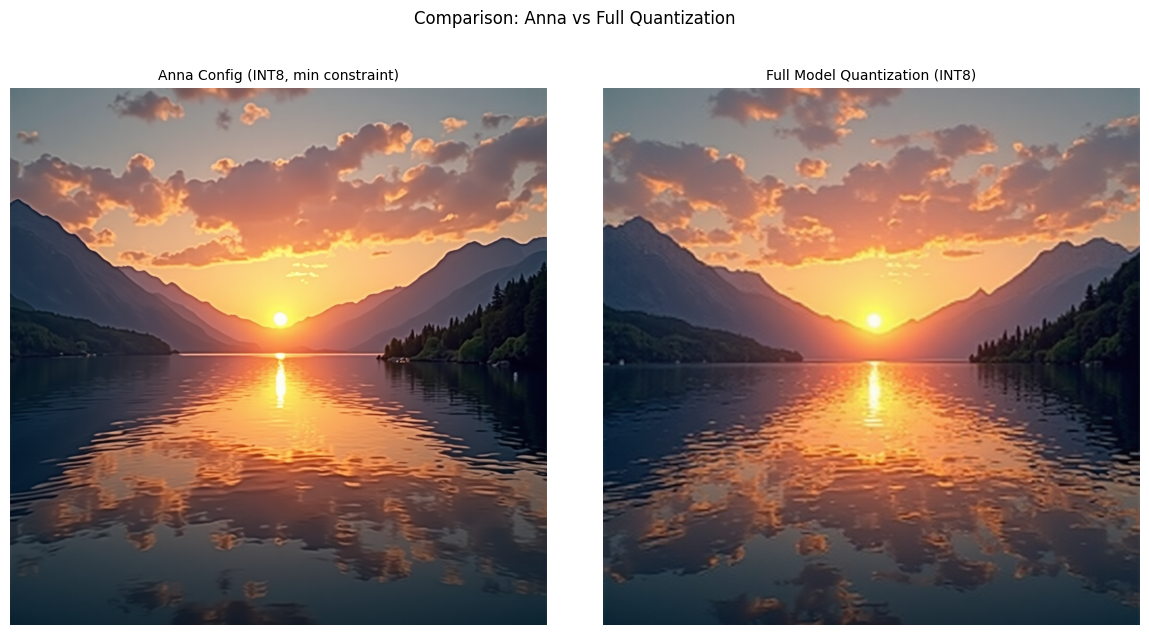

In [19]:
show_images(result, quant_result)

You can see that in the image with **ANNA** there is no minor noise in the image.

## Next Steps

After running this analysis, you can:

1. **Choose optimal configuration**: Review the constraint vs objective values to select the best trade-off
2. **Deploy quantized model**: Use the saved configs to apply quantization in production
3. **Compare image quality**: Examine the evaluation images to assess quality preservation
4. **Fine-tune parameters**: Adjust calibration samples, constraint range, or quantization type for better results
5. **Compile with QLIP**: Use QLIP's compilation tools to further optimize the quantized model for deployment